<a href="https://colab.research.google.com/github/KwonYN/TIL/blob/master/PYTHON/TENSORFLOW2/05_02_cnn_feature_7_kyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **실습 5-2 : CNN Feature Maps**

## **Import Module**

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPool2D, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.layers import Dropout, BatchNormalization

import matplotlib.pyplot as plt

tf.__version__

TensorFlow 2.x selected.


'2.0.0'

## **DataSet**

### Load

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train[..., tf.newaxis]/255., x_test[..., tf.newaxis]/255.

x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

### Preprocessing

## **Model**

### Define

### Model_B define: Batch Normalization 사용 model

In [0]:
def model_cnn_batchnormal():
  x_in = Input(shape=(28,28,1))
  x = Conv2D(64,3,padding='same',activation='relu') (x_in)
  x = BatchNormalization(momentum=0.8)(x)
  x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
  x = Conv2D(64, 3, padding='same', activation='relu')(x) 
  x = BatchNormalization(momentum=0.8)(x) 
  x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
  x = Conv2D(64, 3, padding='same', activation='relu',name='conv3rd', activity_regularizer=keras.regularizers.l1(l=0.001))(x) 
  x = BatchNormalization(momentum=0.8)(x) 
  x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(10, activation='softmax')(x)

  model = Model(x_in, x)
  return model


model_BN=model_cnn_batchnormal()

model_BN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0     

### Compile

In [0]:
model_BN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Fit

Epoch 10/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0367 - accuracy: 0.9887
CPU times: user 32 s, sys: 13.9 s, total: 45.9 s

Wall time: 45.8 s
(@Notebook Setting/GPU)

In [0]:
%%time
history_BN = model_BN.fit(x_train, y_train, 
                        shuffle=True,
                        batch_size=1000, 
                        epochs=20,
                        validation_data=(x_test, y_test)
                        )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 71us/sample - loss: 0.6410 - accuracy: 0.8861 - val_loss: 0.1460 - val_accuracy: 0.9684
Epoch 2/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.1088 - accuracy: 0.9779 - val_loss: 0.1017 - val_accuracy: 0.9771
Epoch 3/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0738 - accuracy: 0.9864 - val_loss: 0.0814 - val_accuracy: 0.9813
Epoch 4/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0560 - accuracy: 0.9897 - val_loss: 0.0794 - val_accuracy: 0.9817
Epoch 5/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0457 - accuracy: 0.9918 - val_loss: 0.0689 - val_accuracy: 0.9848
Epoch 6/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0392 - accuracy: 0.9935 - val_loss: 0.0717 - val_accuracy: 0.9826
Epoch 7/20
60000/60000 [==============================] 

### Filter map

In [0]:
# summarize filter shapes
filter_list = []
for layer in model_BN.layers:
  # check for convolutional layer
  if 'conv' not in layer.name:
    continue
  # get filter weights
  filters, biases = layer.get_weights() # 이 filters 변수는 w의 의미도!!
  filter_list.append(filters)
  print(layer.name, filters.shape)

conv2d (3, 3, 1, 64)
conv2d_1 (3, 3, 64, 64)
conv3rd (3, 3, 64, 64)


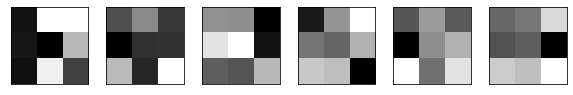

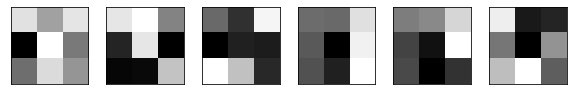

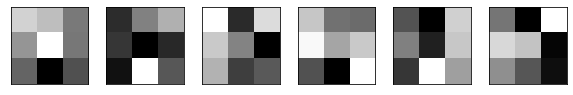

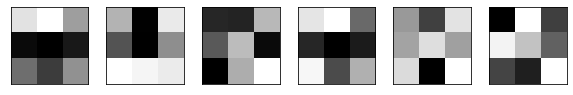

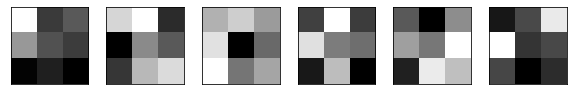

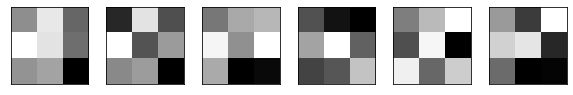

In [0]:
# minmax normalization: 마지막 conv filter
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min) 

# plot filters: 6개 씩
n_filters = 6
for i in range(n_filters):
  # get the filter
  f = filters[:, :, :, i]   # f.shape: (3,3,64)
  # plot each channel separately
  plt.figure(figsize=(10,10))
  for j in range(6):
    p_num = i*n_filters + j 
    # specify subplot and turn of axis
    ax = plt.subplot(n_filters, 6, p_num+1)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, j], cmap='gray')
# show the figure
plt.show()

### Filter map extract model define

In [0]:
# Extracts the outputs of the top 12 layers
#layer_outputs = [layer.output for layer in model_B.layers[:-1]]
ixs = [1, 4, 7]
layer_outputs = [model_BN.layers[i].output for i in ixs]
# Creates a model that will return these outputs, given the model input
# 새로운 모델 생성, 기존 모델의 parameter까지 copy, compile하면 안됨, 기존모델과 독립
fm_model = Model(inputs=model_BN.input, outputs=layer_outputs)#conv2d_6 (Conv2D)   

fm_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0   

In [0]:
#del model_BN

### Feature maps

### Image ploting function

In [0]:
# plot n x n images
def square(imgs, n):
  img_num = n
  plt.figure(figsize=(10,10))
  for i in range(n):
    for j in range(n):
      p_num = i*n + j         
      # specify subplot and turn of axis
      ax = plt.subplot(n, n, p_num+1)   # pic position num: 1 ~ 64
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      plt.imshow(imgs[0, :, :, p_num], cmap='gray')
  # show the figure
  plt.show()

### Get feature maps: fm_model.predict

In [0]:
# Returns a list of five Numpy arrays of layer activation
n=1
feature_maps = fm_model.predict(x_test[n:n+1,:]) 
layers_names = fm_model.output_names

### Plot the feature maps

conv2d


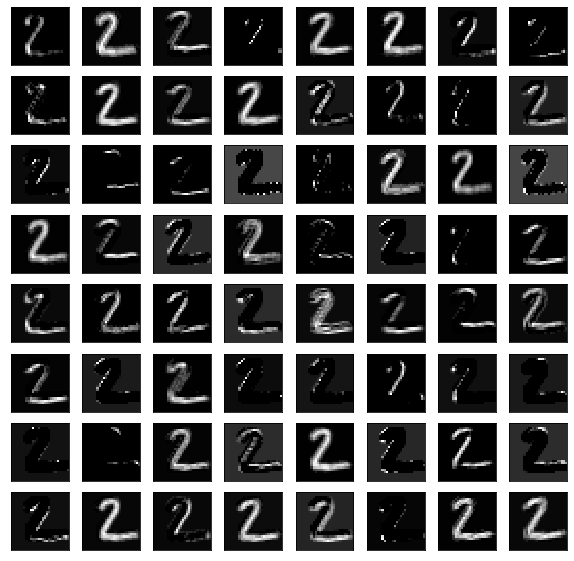

conv2d_1


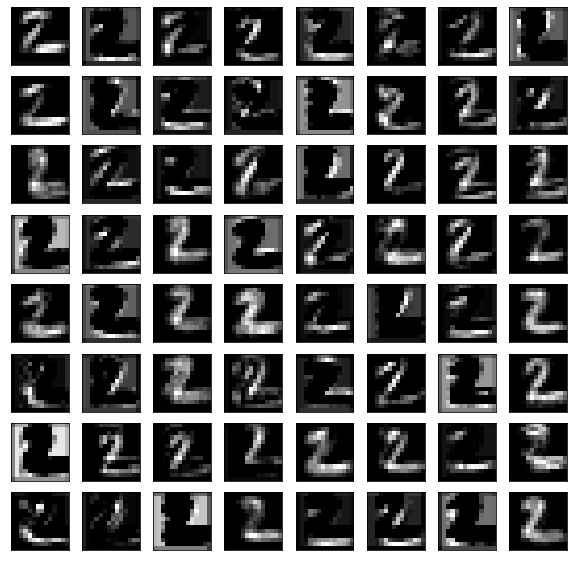

conv3rd


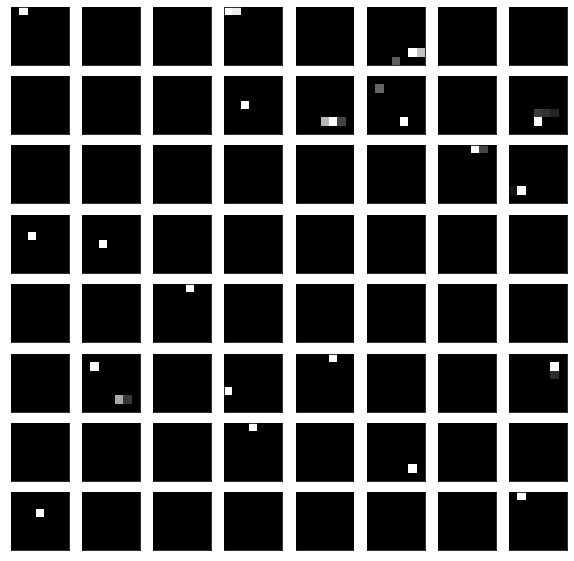

In [0]:
# plot the output from each block
for i, fmap in enumerate(feature_maps):
  print(layers_names[i])
  square(fmap, 8)

## **Analysis**

## **실습 과제**

### 과제1 feature map을 관찰해 보자 
#### -- 세번째 conv3rd layer에 l1 reguralization을 적용하고,
#### -- feature map이 어떻게 바뀌었는지 확인하자
#### -- 결과를 비교하고, 분석하자 :
#### ----- `activity_regularizer=keras.regularizers.l1(l=0.001)`를 써보자 


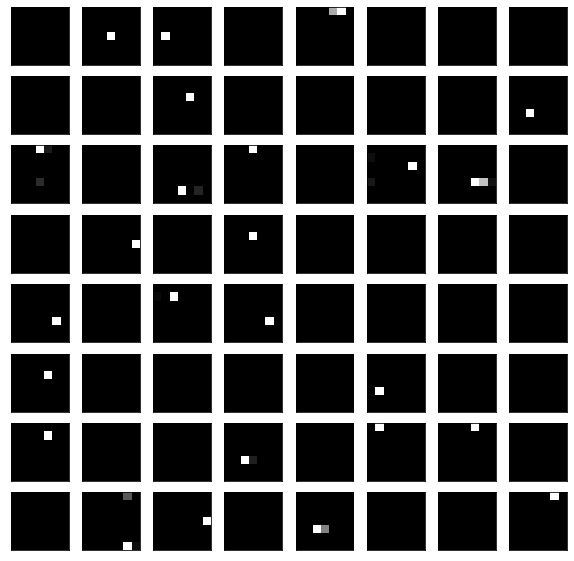

conv_3rd : l1 regularization

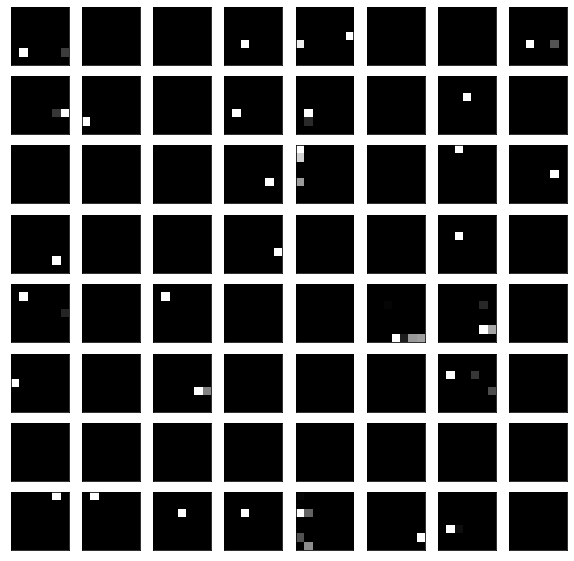

conv_3rd : l2 regularization

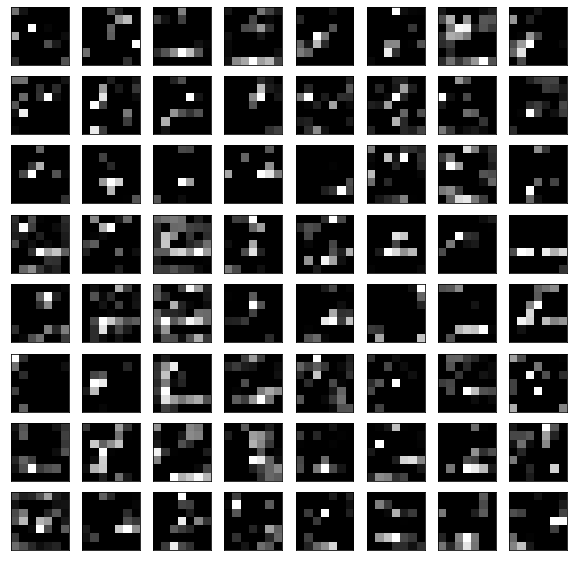

conv_3rd : activity_regularization = None

##### weight가 강한 몇몇 특징들을 보여준다.
##### 

##### 어제 했던 스펙트럼 같은 그림 그려보자!!